### Building an Object Detection Framework

<p style="font-family: times, serif; font-size:14pt; font-style:bold"> To begin with, the snippet below shows how to use exisiting resnet50 model to perform object detection on custom images. Below is example of REST API calls to fetch images from my personal media library https://github.com/Saptarshi-SBU/APIserver</p>

In [ ]:
import requests
import json

response = requests.get('http://10.2.59.13:4040/api/v1/listphotos')
data = response.content
print (data)

In [ ]:
j_data = json.loads(data)
albums_uuid = []
for kv in j_data
    albums_uuid.append(kv['value']['uuid'])
print (albums_uuid)

In [52]:
payload = {'img' : albums_uuid[0]}
response = requests.get('http://10.2.59.13:4040/api/v1/scaledphoto', params=payload)
print(response)
print (response.headers)

{'Content-Type': 'image/jpg', 'Content-Length': '80698', 'Server': 'Werkzeug/0.16.0 Python/2.7.5', 'Date': 'Mon, 11 Jan 2021 02:07:15 GMT'}


### Torch Installation

<p style="font-family: times, serif; font-size:14pt; font-style:bold">Next, lets use conda to install pytorch on the system. I had a lot of trouble installing opencv with python3.7, there seems to be an issue with conda. Follow the following steps:</p>
<p style="font-family: times, serif; font-size:13pt; font-style:italic">
 <br> 1. conda create -n py36 python=3.6</br>
 <br> 2. conda activate py36 </br>
 <br> 3. conda install pytorch torchvision torchaudio cudatoolkit=10.2 opencv -c pytorch </br>
</p>

In [53]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np


# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class
  

In [ ]:
from PIL import Image, ImageFont, ImageDraw
from io import BytesIO

def object_detection_api(img_path, threshold=0.5):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls = get_prediction(img_path, threshold)
  source_img = Image.open(img_path).convert("RGB")
  draw = ImageDraw.Draw(source_img)
  out_file = "torch.jpg"
  for i in range(len(boxes)):
    draw.rectangle(boxes[i], fill=None, outline="yellow", width=5)
    draw.text(boxes[i][0], pred_cls[i], font=ImageFont.truetype("/usr/share/fonts/gnu-free/FreeMono.ttf", 32), fill="red", width=32)
  source_img.save(out_file) 
  im = Image.open(out_file)
  im.show()  
  print (boxes, pred_cls)
  return pred_cls

### Sample Inference and Labeling

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
Now that we had our object detection api ready, we can run inference on a sample image
using the above object detection API</p>

In [ ]:
payload = {'img' : albums_uuid[0]}
response = requests.get('http://10.2.59.13:4040/api/v1/scaledphoto', params=payload)
file_jpgdata = BytesIO(response.content)
object_detection_api(file_jpgdata)

### Concurrent Labelling using DASK

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
Next Below is a sample to run object detection and perform labeling concurrently on a batch of images
python big data framework DASK. Dask is a work scheduler which acts by paritioning dataset and assign
workers to a partition. Since we have thousands of images, the below few lines of code helps us achieve
the required throughput</p>

In [81]:
import requests
import json
import dask
import dask.bag as db
from io import BytesIO

API_HOST = '10.2.59.13'
LISTPHOTOS_API = 'http://{}:4040/api/v1/listphotos'.format(API_HOST)
GETPHOTO_API = 'http://{}:4040/api/v1/scaledphoto'.format(API_HOST)
LABELPHOTO_API = 'http://{}:4040/api/v1/label'.format(API_HOST)

def fetch_all_images():
    albums_uuid = []
    response = requests.get(LISTPHOTOS_URL)
    data = response.content
    j_data = json.loads(data)
    for kv in j_data:
        albums_uuid.append(kv['value']['uuid'])
    return albums_uuid

def label_image(img_uuid):
    response = requests.get(GETPHOTO_URL, params={'img':img_uuid})
    jpgdata = BytesIO(response.content)
    pred_cls = object_detection_api(jpgdata)
    labels = ' '.join(pred_cls)
    response = requests.post(LABELPHOTO_URL, data={'img':img_uuid, 'labels':labels})
    response = requests.get(LABELPHOTO_URL, params={'img':img_uuid})
    print (response.content)

#fetch_all_images()
b = db.from_sequence(albums_uuid[0:16], npartitions=4).map(label_image)
r = b.compute()
    

[[(49.699875, 61.867325), (527.6324, 750.3205)]] ['person']
b'"person"'
[[(310.35916, 18.110456), (665.9717, 459.42868)], [(310.77026, 609.9912), (435.44623, 711.0056)], [(10.206599, 444.7967), (1008.0, 756.0)], [(177.51633, 490.07703), (314.01196, 572.94586)], [(557.04407, 589.51434), (678.3497, 686.18567)], [(588.5785, 521.7588), (689.3299, 600.59076)], [(142.30682, 506.6534), (251.05882, 545.9602)], [(433.95364, 623.8414), (554.6413, 723.4723)], [(506.91428, 490.52795), (559.3247, 527.59546)]] ['person', 'bowl', 'dining table', 'bowl', 'bowl', 'bowl', 'spoon', 'bowl', 'donut']
b'"person bowl dining table bowl bowl bowl spoon bowl donut"'
[[(164.95193, 247.10779), (583.1691, 999.88477)], [(0.0, 1.0117171), (86.66291, 268.19583)], [(619.72235, 686.3288), (728.5662, 811.3008)], [(168.11859, 3.3667922), (628.5089, 186.56113)], [(39.11149, 34.989086), (715.9636, 874.48486)]] ['person', 'person', 'remote', 'person', 'bed']
[[(15.77534, 152.84142), (731.1579, 871.7225)], [(0.0, 525.70044),

### Datasets, DataLoaders

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
Next Lets focus on building a pytorch based dataset for our Component Counting project
In order to train a PyTorch neural network you must write code to read training data into memory,
convert the data to PyTorch tensors, and serve the data up in batches. </p>

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
The below code snippet creates a PyTorch based DataSet Class for our PID Dataset.
Images are annotated using the labelImg too. Next they are converted to a DataFrame using the below listed recipes.
</p>

<p style="font-family: times, serif; font-size:14pt; font-style:italic">
<br>pascal_voc_xml_to_csv method : Prepare a DataFrame Object from the xml files</br>
<br>CustomImageDataset class : Prepare a PyTorch Dataset Object from the DataFrame</br>
<br>CustomImageDataLoader class : Prepare a PyTorch DataLoader which is fed to the Model for training</br>
</p>

In [122]:
import os
import pandas as pd
from glob import glob
import xml.etree.ElementTree as ET

def pascal_voc_xml_to_df(data_dir, max_files):
    '''
      The recipe is used to convert images annotations
      in pascal voc format to the DataFrame format.
    '''
    xml_list = []
    counter = 0
    for xml_file in glob(data_dir + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        size = root.find('size')
        width = size.find('width').text      
        height = size.find('height').text
        for member in root.findall('object'):
            box = member.find('bndbox')
            label = member.find('name').text
            row = (filename, width, height, label, int(float(box.find('xmin').text)), int(float(box.find('ymin').text)),
               int(float(box.find('xmax').text)), int(float(box.find('ymax').text)), counter)
            xml_list.append(row)
        column_names = ['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax', 'image_id']
        xml_df = pd.DataFrame(xml_list, columns=column_names)
        #print (xml_df)
        counter += 1
        if counter > max_files:
            break
        
    #xml_df.to_csv('xml2csv.csv')
    return xml_df

In [123]:
import numpy
import torch
import torchvision
import cv2
from torchvision import transforms
from PIL import Image

class CustomImageDataset(torch.utils.data.Dataset):
    '''
        Map Style Dataset
        https://pytorch.org/docs/stable/data.html#dataset-types
    '''
    
    def __init__(self, data_dir, max_files=512):
        self.data_dir = data_dir
        self.df = pascal_voc_xml_to_df(data_dir, max_files) # dataframe
        self.transform = transforms.Compose([transforms.ToTensor(), \
            transforms.Normalize(mean=[0.485, 0.456, 0.406], \
                                 std=[0.229, 0.224, 0.225])])
            #transforms.Normalize(mean=[0.5, 0.5, 0.5], \
            #                     std=[0.5, 0.5, 0.5])]) 
        self.classes = []
        
    def __len__(self):
        return len(self.df['image_id'].unique().tolist())
    
    def __img2tensor(self, img):
        if self.transform:
            for t in self.transform.transforms:
                img = t(img)
        return img
    
    def __bboxes2tensor(self, bboxes):
        return torch.tensor(bboxes).view(-1, 4)
    
    def __labels2tensor(self, labels):
        for label in set(labels):
            if label not in self.classes:
                self.classes.append(label)
        label_intarray = [self.classes.index(label) + 1 for label in labels]
        return torch.tensor(label_intarray)
        #return torch.ones((len(labels)), dtype=torch.int64)
    
    def __getitem__(self, idx):
        '''
            https://pandas.pydata.org/docs/user_guide/dsintro.html
            This function implement's Torch Dataset __getitem__
        '''
        boxes = []
        labels = []
        targets = {}
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #print (self.df)
        object_entries = self.df.loc[self.df['image_id'] == idx]
        filename = object_entries.iloc[0, 0]
        imgpath = '{}/{}'.format(self.data_dir, filename)
        img = cv2.imread(imgpath)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
            raise Exception("invalid image path {}".format(imgpath))
        for i in range(0, object_entries.shape[0]):
            box = object_entries.iloc[i, 4:8]
            boxes.append(box)
            label = object_entries.iloc[i, 3]
            labels.append(label)
        img = self.__img2tensor(img)
        targets['boxes'] = self.__bboxes2tensor(boxes)
        targets['labels'] = self.__labels2tensor(labels)
        targets['image_id'] = torch.tensor([idx])
        return img, targets, imgpath
      
class CustomImageDataLoader(torch.utils.data.DataLoader):
    
    def __init__(self, dataset, **kwargs):
        super().__init__(dataset, collate_fn=CustomImageDataLoader.collate_data, **kwargs)
        
    @staticmethod    
    def collate_data(batch):
        images, targets, paths = zip(*batch)
        return list(images), list(targets), list(paths)



### Apply Our DataLoader to a Sample Model for Training

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
 Next, lets feed our CustomDataset to a pre-trained model, using our customDataLoader
 for a quick sanity test. Please note that the model that was used has the pretrained
 flag set to False. This means that we are just using the network as is and not using
 any pre-trained weights.
</p>

### Need for Batching

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
The reason we want to do batching is multifaceted. One big motivation is to make
sure the computation we’re asking for is big enough to saturate the computing
resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle.
By providing batches of inputs, the calculation can be spread across the otherwise-idle
units, which means the batched results come back just as quickly as a single result
would. Another benefit is that some advanced models use statistical information from
the entire batch, and those statistics get better with larger batch sizes.
</p>

images : 5 total epochs : 1
begin epoch :0
tensor(2.6122, grad_fn=<AddBackward0>)
tensor(2.3391, grad_fn=<AddBackward0>)
end epoch :0


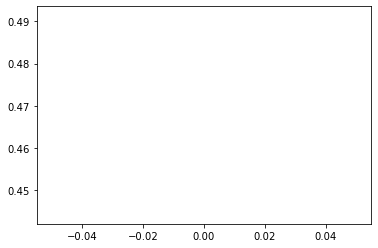

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


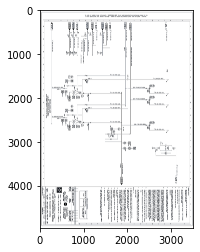

Predicted Image :data/Annotations/6987_64_1118 REV0.jpg


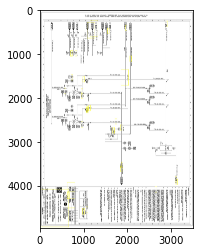

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


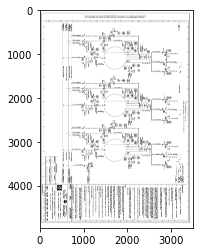

Predicted Image :data/Annotations/6987_65_1111 REV0.jpg


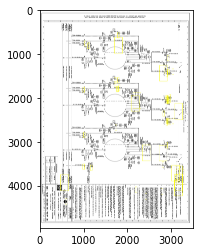

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


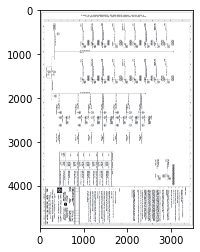

Predicted Image :data/Annotations/6987_64_1112 REV0.jpg


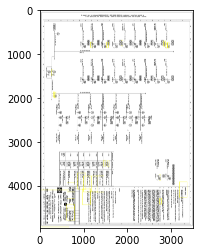

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


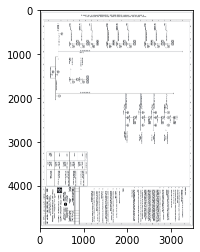

Predicted Image :data/Annotations/6987_64_1119 REV0.jpg


In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn  import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    '''
        image helper
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def drawbbox(img_path, boxes, suffix):
    '''
        draws bounding boxes on the image
    '''
    source_img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(source_img)
    out_file = img_path.replace('.jpg', '_{}.jpg'.format(suffix))
    for i in range(len(boxes)):
        draw.rectangle(boxes[i].tolist(), fill=None, outline="yellow", width=5)
        #draw.text(boxes[i][0], pred_cls[i], font=ImageFont.truetype("/usr/share/fonts/gnu-free/FreeMono.ttf", 32), fill="red", width=32)
    source_img.save(out_file) 
    img = Image.open(out_file)  
    plt.imshow(numpy.asarray(img))
    plt.show()
    
def verify_labelled_images(data_dir):
    '''
        re-generates images with bounding boxes
    '''
    dataset = CustomImageDataset(data_dir)   
    loader = CustomImageDataLoader(dataset, batch_size=1, shuffle=True)
    for images, targets, sources in loader:
        imshow(torchvision.utils.make_grid(images))
        bboxes = targets[0]['boxes']
        bboxes = bboxes.detach().numpy()
        print ('labelled image :{}'.format(sources[0]))
        drawbbox(sources[0], bboxes, 'orig')

def get_num_correct(preds, labels):
    '''
        compute accuracy
    '''
    #return preds.argmax(dim=1).eq(labels).sum().item()
    return preds.eq(labels).sum().item()

#dataset = CustomImageDataset(data_dir)
#my_ldr = CustomImageDataLoader(dataset, batch_size=10, shuffle=True)
#for (idx, batch) in enumerate(my_ldr):
#    print (idx, batch)
            
def train_dataset(data_dir, epochs, batch_size, max_files=512):
    '''
        train the model
    '''
    num_classes = 1 # ball-valve
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                             progress=True,
                                                             num_classes=num_classes + 1,#for background
                                                             pretrained_backbone=True)
    model.train()
    # Get parameters that have grad turned on (i.e. parameters that should be trained)
    parameters = [p for p in model.parameters() if p.requires_grad]
    # Create an optimizer that uses SGD (stochastic gradient descent) to train the parameters
    optimizer = torch.optim.SGD(parameters, lr=0.005, momentum=0.9, weight_decay=0.0005)
    #optimizer = torch.optim.SGD(parameters, lr=0.001, momentum=0.9, weight_decay=0.0005)
    # Create a learning rate scheduler that decreases learning rate by gamma every lr_step_size epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    #print (model)
    #print (parameters)
    
    #train loader
    dataset = CustomImageDataset(data_dir, max_files)   
    train_loader = CustomImageDataLoader(dataset, batch_size=batch_size, shuffle=True)
    print('images : {} total epochs : {}'.format(dataset.__len__(), epochs))
    losses = []
    for epoch in range(epochs):
        print ("begin epoch :{}".format(epoch))
        running_loss = 0
        for images, targets, paths in train_loader:
            #print(images[0].shape, targets[0])
            #imshow(torchvision.utils.make_grid(images))
            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())
            print (total_loss)
            running_loss =+ total_loss.item() * len(images)
            # Zero any old/existing gradients on the model's parameters
            optimizer.zero_grad()
            # Compute gradients for each parameter based on the current loss calculation
            total_loss.backward()
            # Update model parameters from gradients: param -= learning_rate * param.grad
            optimizer.step()
        losses.append(running_loss / len(dataset))
        lr_scheduler.step()
        print ("end epoch :{}".format(epoch))
    plt.plot(losses)
    plt.show()
    return model


#We have annotated the function using the @torch.no_grad() PyTorch decoration.
#This is because we want this functions execution to omit gradient tracking.
#This is because gradient tracking uses memory, and during inference (getting predictions while not training)
#there is no need to keep track of the computational graph. The decoration is one way of locally
#turning off the gradient tracking feature while executing specific functions.
@torch.no_grad()      
def eval_dataset(model, data_dir, max_files=512):
    '''
        for inference
    '''
    model.eval()
    #validation loader
    all_preds = torch.tensor([])
    all_targets = torch.tensor([])
    dataset = CustomImageDataset(data_dir, max_files) 
    val_loader = CustomImageDataLoader(dataset, batch_size=1, shuffle=True)
    for images, targets, sources in val_loader:
        predictions = model(images)  # Returns predictions
        imshow(torchvision.utils.make_grid(images))
        #print ('Predictions :', predictions)
        bboxes_preds = predictions[0]['boxes']
        bboxes_targets = targets[0]['boxes']
        #print(nn.CrossEntropyLoss(bboxes_preds, bboxes_targets)
        print ('Predicted Image :{}'.format(sources[0])) 
        drawbbox(sources[0], bboxes_preds.detach().numpy(), 'pred')
        all_preds = torch.cat((all_preds, bboxes_preds),dim=0)
        all_targets = torch.cat((all_targets, bboxes_targets),dim=0)
        #bboxes_targets = bboxes.detach().numpy()
    total_correct = get_num_correct(all_preds, all_targets)
    print ('total correct :{} accuracy :{}'.format(total_correct, total_correct/len(dataset)))
              
#main       
epochs = 1
batch_size = 4
md = train_dataset('data/Annotations', epochs, batch_size, max_files=4)
eval_dataset(md, 'data/Annotations', max_files=4)
#verify_labelled_image('data/Annotations')

### The Mechanics of Learning

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
Basic concepts on Linear Functions, Convex Functions, Gradient Descent, back propagation (calculus on partial derivatives)
</p>

In [ ]:
import torch
import matplotlib.pyplot as plt

# temperature in celsius (input)
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
# temperature in farhenheit (unknown)
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
plt.plot(t_c, t_u, 'bo') 
plt.show()

### Learning for a Logistic Regression Model

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
Calibration Model for Temperature
</p>

initial params: tensor([1., 0.])
Epoch 1000 Loss 3
final params: tensor([  4.8021, -14.1031])


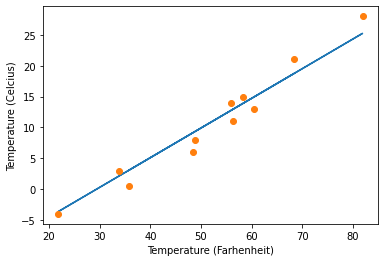

In [20]:
def model(t_u, w, b):
    '''
        t_u : input tensor
        w   : weight
        b   : bias parameter
    '''
    return w * t_u + b

def loss_fn(t_p, t_c):
    '''
        mean square loss
    '''
    sq_delta = (t_p - t_c) ** 2
    return sq_delta.mean()

def d_loss_fn(t_p, t_c):
    '''
        derivative of loss function
    '''
    dsq_delta = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_delta

def d_model_dw(t_u, w, b):
    '''
        derivative of loss function w.r.t w
    '''
    return t_u

def d_model_db(t_u, w, b):
    '''
        derivative of loss function w.r.t b
    '''
    return 1

def grad_fn(t_u, t_c, t_p, w, b):
    '''
        overall gradient function (based on chain rule)
    '''
    dloss_dtp = d_loss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * d_model_dw(t_u, w, b)
    dloss_db = dloss_dtp * d_model_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        params = params - learning_rate * grad
        #print ('Epoch %d Loss %d' % (epoch, float(loss)))
    print ('Epoch %d Loss %d' % (epoch, float(loss)))
    return params

w = torch.ones(())
b = torch.zeros(())
print ('initial params:', torch.tensor([w,b]))
'''
lr : 1e-2 -> 1e-4
normalize : t_u -> 0.1 * t_u
'''
params = training_loop(n_epochs=1000, learning_rate= 1e-2, params=torch.tensor([1.0, 0.0]), t_u=0.1*t_u, t_c=t_c)
print ('final params:', params)

t_p = model(t_u*0.1, *params)
plt.xlabel("Temperature (Farhenheit)")
plt.ylabel("Temperature (Celcius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

### Back propagation in PyTorch

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
Even if we have a complicated model with millions of parameters, as long as our
model is differentiable, computing the gradient of the loss with respect to the parameters amounts to writing the analytical expression for the derivatives and evaluating
them once. PyTorch tensors can remember where they come from, in terms of the operations and
parent tensors that originated them, and they can automatically provide the chain of
derivatives of such operations with respect to their inputs. This means we won’t need
to derive our model by hand; given a forward expression, no matter how nested,
PyTorch will automatically provide the gradient of that expression with respect to its
input parameters</p>

In [29]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
        #print ('Epoch %d Loss %d' % (epoch, float(loss)))
    print ('Epoch %d Loss %d' % (epoch, float(loss)))
    return params

print (t_u)
params = training_loop(n_epochs=1000, learning_rate= 1e-2, params=torch.tensor([1.0, 0.0], requires_grad=True), t_u=0.1*t_u, t_c=t_c)
print ('final params:', params)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 1000 Loss 3
final params: tensor([  4.8021, -14.1031], requires_grad=True)


### Gradient descent in PyTorch (autograd)

<p style="font-family: times, serif; font-size:14pt; font-style:bold">
The below snippet uses Stochastic Gradient Descent (SGD) for adaptively
tuning the regularization parameters.
</p>

In [40]:
import torch.optim as optim

def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    optimizer = optim.SGD([params], lr=learning_rate)
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print ('Epoch %d Loss %d' % (epoch, float(loss)))
    return params

print (t_u)
params = training_loop(n_epochs=1000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0], requires_grad=True), t_u=0.1*t_u, t_c=t_c)
print ('final params:', params)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
Epoch 500 Loss 7
Epoch 1000 Loss 3
final params: tensor([  4.8021, -14.1031], requires_grad=True)


### Learning using a Neural Network Model in PyTorch (Logistic Regression)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 500 Loss 13
Epoch 1000 Loss 9
Epoch 1500 Loss 3
Epoch 2000 Loss 2
Epoch 2500 Loss 2
Epoch 3000 Loss 2
Epoch 3500 Loss 1
Epoch 4000 Loss 1
Epoch 4500 Loss 1
Epoch 5000 Loss 1
final params: [Parameter containing:
tensor([[-0.5740],
        [-1.1253],
        [ 1.6238],
        [ 0.8448],
        [ 0.5212],
        [ 0.5132],
        [-1.4025],
        [-0.5285],
        [-1.3524],
        [-1.1221],
        [ 1.4172],
        [-1.2060],
        [-0.8740]], requires_grad=True), Parameter containing:
tensor([ 3.4012,  5.5251, -8.0341, -1.3992, -0.2177,  0.1784,  6.8898,  3.9147,
         9.1378,  2.3132, -9.5153,  8.2692,  1.5004], requires_grad=True), Parameter containing:
tensor([[-0.4751, -1.2015,  2.1832,  2.6727,  3.0512,  2.7052, -1.9381, -0.5102,
         -2.3892, -2.2042,  2.5944, -1.9504, -2.5204]], requires_grad=True), Parameter containing:
tensor([2.4789], requires_grad=True)]


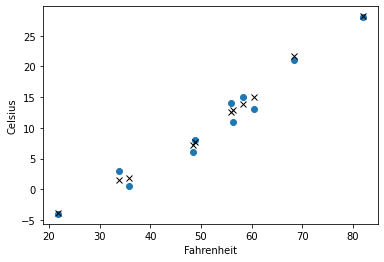

In [35]:
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt

def training_loop(n_epochs, model, learning_rate, params, t_u, t_c):
    optimizer = optim.SGD(params, lr=learning_rate)
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u)
        #loss = nn.MSELoss(t_p, t_c)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print ('Epoch %d Loss %d' % (epoch, float(loss)))

seq_model = nn.Sequential(nn.Linear(1,13), nn.Tanh(), nn.Linear(13, 1))
print (seq_model)
t_un = 0.1 * t_u
#conver to row based inputs
t_un = torch.tensor(t_un).unsqueeze(1)
t_cn = torch.tensor(t_c).unsqueeze(1)
#print (t_un, t_cn)
training_loop(n_epochs=5000, model=seq_model, learning_rate=1e-2, params=seq_model.parameters(), t_u=t_un, t_c=t_cn)
print ('final params:', list(seq_model.parameters()))
#plot model output
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_u.numpy(), seq_model(t_un).detach().numpy(), 'kx')

### Building a Custom Neural Network Template on CIFAR10 Image Dataset

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/mnt/cifar10', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='/mnt/cifar10/', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


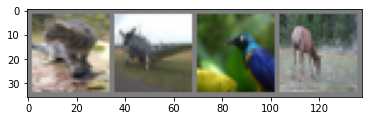

  cat plane  bird  deer


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [14]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000), loss.item())
            running_loss = 0.0

print('Finished Training')
PATH = '/mnt/cifar10/cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 0.843
1.122056484222412
[1,  4000] loss: 0.850
2.2851006984710693
[1,  6000] loss: 0.887
1.7495520114898682
[1,  8000] loss: 0.882
0.5574830174446106
[1, 10000] loss: 0.905
1.2449227571487427
[1, 12000] loss: 0.919
0.7461568117141724
[2,  2000] loss: 0.807
0.7614113092422485
[2,  4000] loss: 0.829
0.6022888422012329
[2,  6000] loss: 0.858
1.0757396221160889
[2,  8000] loss: 0.864
0.2295873761177063
[2, 10000] loss: 0.855
1.6568267345428467
[2, 12000] loss: 0.885
0.6569117903709412
Finished Training


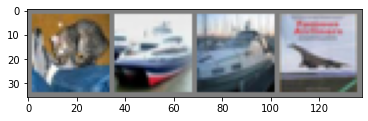

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))